# EC analysis - individual image corrections

- this script serves as an addition to the EC analysis, which allows user to adjust individual parameters of the thresholding funcitons and correct inaccuracies in the image mask

- this script separtes the area analysis and distance analysis - this is because the problem with masks is usually with the way myocardium/epicardium or organoid areas are defined. This has absolutely no impact on the distance analysis. Individual image correction for distance analysis only needs t obe done if the EC/macrophage mask changes.
    - both are not done at the same time because the distances analysis takes longer

In [1]:
### LIBRARY
import os
import glob
from skimage import io
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from skimage.filters import try_all_threshold
from skimage.filters import threshold_minimum, threshold_isodata, threshold_triangle, threshold_mean
from skimage.filters import threshold_otsu, threshold_li, threshold_yen
from skimage.morphology import binary_dilation
from scipy.ndimage import binary_erosion
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import watershed
from skimage.filters import gaussian
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.morphology import remove_small_objects
from skimage.morphology import remove_small_holes
from skimage.morphology import disk
from scipy.ndimage import binary_dilation
from scipy.spatial.distance import cdist
from statistics import mean, stdev
from natsort import natsorted
from skimage.exposure import equalize_adapthist

## addition for distances:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import measure
from skimage.segmentation import find_boundaries
import math

In [2]:
### PARAMETERS
filename = 'C:/Users/terez/Documents/Skola/Ludwig-Maximilians_Universitat_Munchen/Research course Moretti lab/Microscopy data etc/Epi2542_EXP20/20251105_Epi2542_d10_perfused_20k_macs_DAPI_cTnT_veCad'

# filename extract
last_folder = os.path.basename(filename)
# output folder:
output_folder = 'C:/Users/terez/Documents/Skola/Ludwig-Maximilians_Universitat_Munchen/Research course Moretti lab/Microscopy data etc/Epi2542_EXP20'

# for masks + image extraction:
folder1 = f'{filename}/masks_with_nuclei_count'
folder2 = f'{filename}/masks_nuclei'
os.makedirs(folder1, exist_ok=True)
os.makedirs(folder2, exist_ok=True)

print(last_folder)

# to correctly extract the channels:
nuclei_mask_suffix = '_ch00_mask.tif'
ch405_suffix = '_ch00.tif'
ch488_suffix = '_ch01.tif'
ch594_suffix = '_ch02.tif'
ch647_suffix = '_ch03.tif'

# to correctly calculate the area:
pixel_size_5x = 1.3
pixel_size_10x = 0.65
pixel_size_20x = 0.325
pixel_size_40x = 0.1625
pixel_size_63x = 0.103125

# to correctly calculate mac sizes for the distances and random distribution:
estimated_mac_radius = 8 #in um
measured_dist_around_EC = 29.9 #in um (for the distances calculation - how far from the EC does mac count as relevant)
estimated_mac_area = math.pi*(estimated_mac_radius**2)

20251105_Epi2542_d10_perfused_20k_macs_DAPI_cTnT_veCad


In [3]:
### LOADING IMAGES

## DAPI in 405 channel:
list_of_dapi_files = natsorted(glob.glob(f"{filename}/*ch00*.tif"))
images_dapi = {}
images_dapi_list = []
for file in list_of_dapi_files:
    img = io.imread(file)
    images_dapi[os.path.basename(file)] = img
    images_dapi_list.append(img)

## 488 channel:
list_of_488_files = natsorted(glob.glob(f"{filename}/*ch01*.tif"))
images_488 = {}
for file in list_of_488_files:
    img = io.imread(file)
    images_488[os.path.basename(file)] = img

## 594 channel:
list_of_594_files = natsorted(glob.glob(f"{filename}/*ch02*.tif"))
images_594 = {}
for file in list_of_594_files:
    img = io.imread(file)
    images_594[os.path.basename(file)] = img

## 647 channel:
list_of_647_files = natsorted(glob.glob(f"{filename}/*ch03*.tif"))
images_647 = {}
for file in list_of_647_files:
    img = io.imread(file)
    images_647[os.path.basename(file)] = img

print(f"to check: \n number of 405 images: \t {len(images_dapi)}, \n number of 488 images: \t {len(images_488)},"
      f"\n number of 594 images: \t {len(images_594)}, \n number of 647 images: \t {len(images_647)}")


to check: 
 number of 405 images: 	 15, 
 number of 488 images: 	 15,
 number of 594 images: 	 15, 
 number of 647 images: 	 15


In [4]:
## Grabbing the cellpose masks from the folder

list_of_nuclei_mask_files = natsorted(glob.glob(f"{folder2}/*.tif"))
nuclei_masks = {}

for file in list_of_nuclei_mask_files:
    img = io.imread(file)
    nuclei_masks[os.path.basename(file)] = img

print(f'Number of nuclei masks: {len(nuclei_masks)}')

Number of nuclei masks: 15


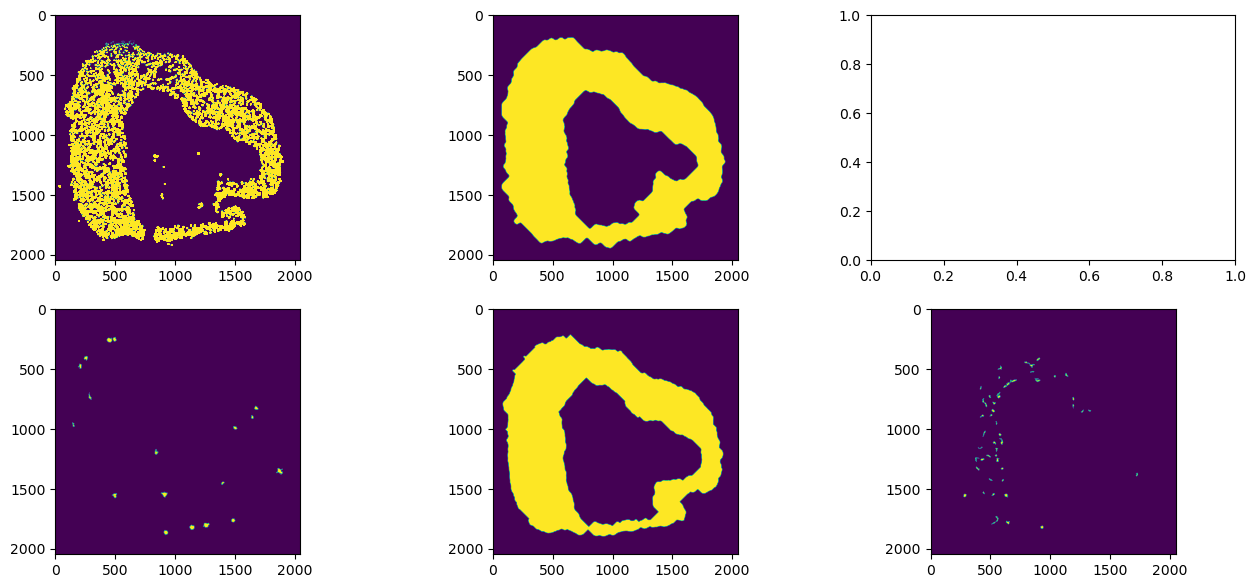

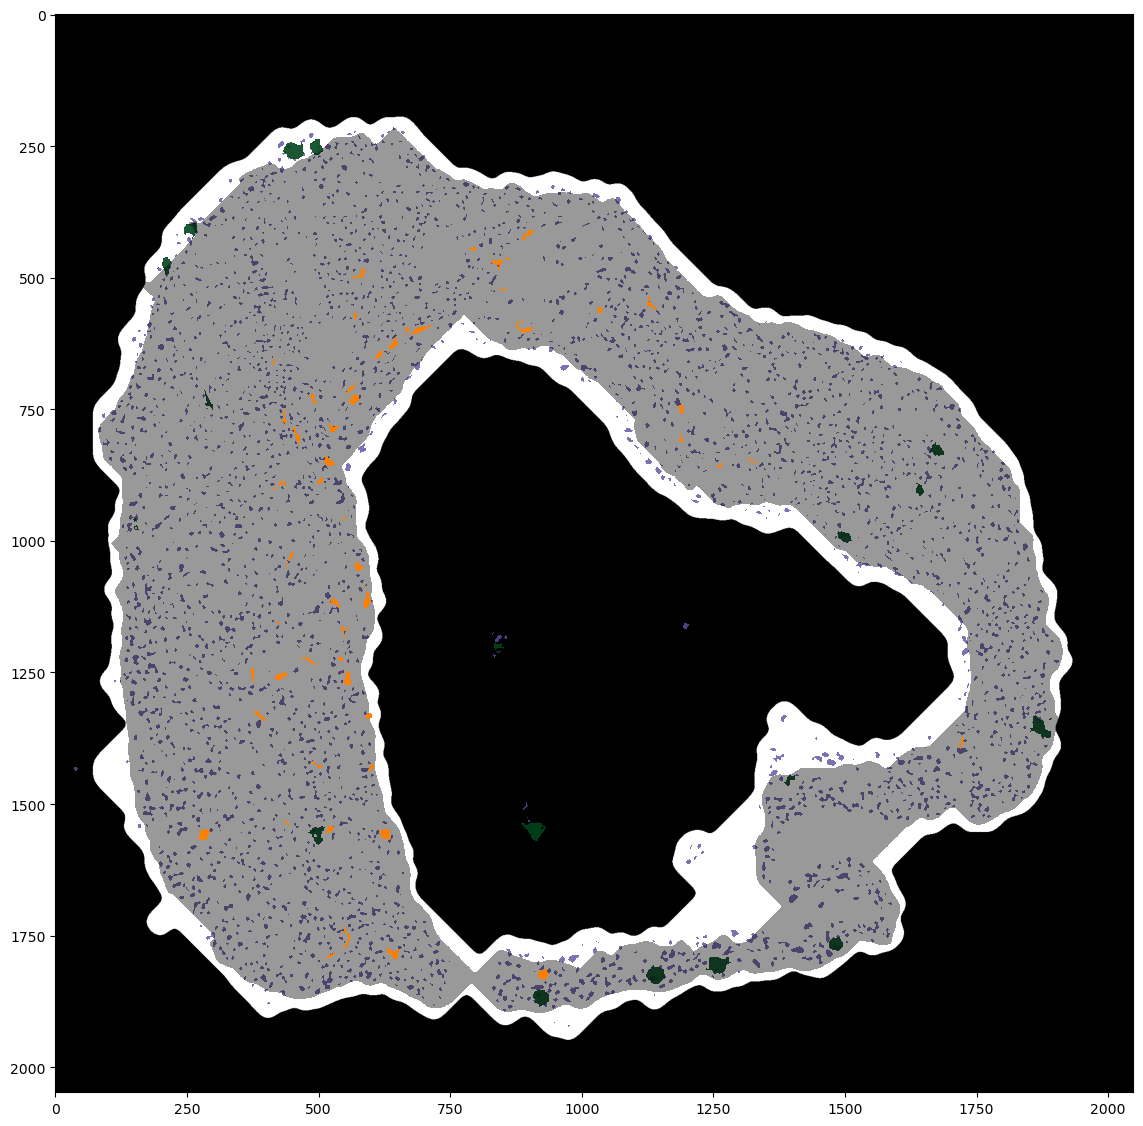

In [ ]:
### PARAMETERS testing

tested_image = 'Series010_ICC' #'Image 1'
default_pixel_size = pixel_size_10x # THIS IS THE ONE THAT WILL GET USED!

def dapi_analysis(mask):
    thresholding = mask > threshold_triangle(mask)
    dilated = binary_dilation(thresholding, iterations=100) #dilates the individual nuclei by 100 pixels
                                                            #this covers up the holes/spaces in between
                                                            #also bridges whatever cavities etc. are present 
    thresholding_2 = remove_small_holes(dilated, area_threshold=10000) #removes the remaining holes
    eroded = binary_erosion(thresholding_2, iterations=80) #erodes the expanded mask back to original size
                                                           #basically 'tightens' the mask to better fit the 
                                                           #organoid
    thresholding_3 = remove_small_objects(eroded, min_size=8000) #removes stray nuclei outside of the organoid
    blurred = gaussian(thresholding_3, sigma=10) #blurrs the jagged edges
    smoothed = blurred > 0.2 #blurring makes the image non-binary, this makes it binary again by selecting
                             #the intensities over certain threshold (in this case everything over 20%)
    return(smoothed)

## 488
def analysis_488(image):
    thresholding_1 = image > threshold_triangle(image) #originaly otsu
    thresholding_2 = remove_small_objects(thresholding_1, min_size=200) #100
    return(thresholding_2)

## 594
def analysis_594(image):
    blurring = gaussian(image,sigma=10) #blurred, because the channel has a lot of debri/unclear signal
                                        #this pools the signal together/removes some of the background
    thresholding = blurring > threshold_li(blurring)
    thresholding_1 = remove_small_objects(thresholding, min_size=5000)
    dilated = binary_dilation(thresholding_1, iterations=60)
    thresholding_2 = remove_small_holes(dilated, area_threshold=100000)
    eroded = binary_erosion(thresholding_2, iterations=60)
    thresholding_3 = remove_small_objects(eroded, min_size=15000)
    return(thresholding_3)

## 647
def analysis_647(image):
    normalisation = equalize_adapthist(image, clip_limit=0.004) #0.009
    thresholding_1 = normalisation > threshold_triangle(normalisation) #NOTE: using a specific threshold 
                                                                       #value is usually fastest for individual images
    thresholding_2 = remove_small_objects(thresholding_1, min_size=150)
    return(thresholding_2)



### Implementation to actual data:

image_dapi_test = nuclei_masks[f'{tested_image}{nuclei_mask_suffix}']
image_thresholded = dapi_analysis(image_dapi_test)

image_488_test = images_488[f'{tested_image}{ch488_suffix}']
thresholded_488_test = analysis_488(image_488_test)

image_594_test = images_594[f'{tested_image}{ch594_suffix}']
thresholded_594_test = analysis_594(image_594_test)

image_647_test = images_647[f'{tested_image}{ch647_suffix}']
thresholded_647_test = analysis_647(image_647_test)


# ## testing of thresholding:
# # tries all automatic thresholding options for the image 
# fig, ax = try_all_threshold(mask_blur_dapi, figsize=(6, 12), verbose=False)
# plt.show()

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,7))
axs[0,0].imshow(image_dapi_test, cmap='viridis', vmin=0, vmax=15)
axs[0,1].imshow(image_thresholded)
axs[1,0].imshow(thresholded_488_test)
axs[1,1].imshow(thresholded_594_test)
axs[1,2].imshow(thresholded_647_test)

fig, ax = plt.subplots(figsize=(14, 14))
# Show background image
ax.imshow(image_thresholded, cmap='gray')
# Nuclei
ax.imshow(np.ma.masked_where(image_dapi_test == 0, image_dapi_test), cmap='Spectral', vmin=0, vmax=1, alpha=0.8)
# macrophages
ax.imshow(np.ma.masked_where(thresholded_488_test == 0, thresholded_488_test), cmap='Greens', vmin=0, vmax=1, alpha=0.9)
# myocardium
ax.imshow(np.ma.masked_where(thresholded_594_test == 0, thresholded_594_test), cmap='magma', alpha=0.4)
# EC
ax.imshow(np.ma.masked_where(thresholded_647_test == 0, thresholded_647_test), cmap="Wistia_r", alpha=1)

In [ ]:
### Analysis (NOT distances)

pixel_size = default_pixel_size
print(pixel_size)

### Creation of masks for the individual channels in the image:   
                                                
## 405 (DAPI)
mask_405 = nuclei_masks[f'{tested_image}{nuclei_mask_suffix}'] #_ch00.tif_mask.tif
thresholded_405 = dapi_analysis(mask_405) # organoid mask by blurring nuclei together
nuclei_objects = regionprops(mask_405, img)
## 488 (macs)
img_488 = images_488[f'{tested_image}{ch488_suffix}']
thresholded_488 = analysis_488(img_488) & thresholded_405 #only signal overlapping with organoid mask is captured
## 594 (cTnT)
img_594 = images_594[f'{tested_image}{ch594_suffix}']
myocardium = analysis_594(img_594) & thresholded_405
## 647 (EC)
img_647 = images_647[f'{tested_image}{ch647_suffix}']
thresholded_647 = analysis_647(img_647) & thresholded_405


### Calculations:

#DAPI signal/organoid size
organoid_size = np.sum(thresholded_405) #sum of all pixels, area in pixels^2
organoid_size_in_um = organoid_size*(pixel_size**2) #area in um^2
number_of_nuclei = mask_405.max() #number of nuclei detected by cellpose

# GFP signal/mac area
overal_488_signal = np.sum(thresholded_488) #sum of all pixels, area in pixels^2
mac_signal_in_um = overal_488_signal*(pixel_size**2)

# 594 signal/cTnT area
myocardium_area = np.sum(myocardium)
myocardium_area_in_um = myocardium_area*(pixel_size**2)
cTnT_per = myocardium_area/organoid_size

epicardium = thresholded_405 & (~myocardium)
epicardium_size = np.sum(epicardium)
epicardium_size_in_um = epicardium_size*(pixel_size**2)
epicardium_area_per = epicardium_size/organoid_size

#number of nuclei in myocardium:
nuclei_count_myo = 0
nuclei_count_epi = 0

nuclei_sizes_in_um = []

for obj in nuclei_objects:
    coordinates = obj.coords
    nucleus_area = obj.area
    nuclei_sizes_in_um.append(nucleus_area*(pixel_size**2))

    # nuclei in myocardium
    overlap_myo = np.sum(myocardium[coordinates[:,0], coordinates[:,1]])
    overlap_myo_per = overlap_myo/nucleus_area
    # nuclei in epicardium
    overlap_epi = np.sum(epicardium[coordinates[:,0], coordinates[:,1]])
    overlap_epi_per = overlap_epi/nucleus_area

    if overlap_myo_per > 0.5:
        nuclei_count_myo += 1

    if overlap_epi_per > 0.5:
        nuclei_count_epi += 1


if nuclei_count_epi ==0:
    print(f"There is no epicardium in: {tested_image}")

if (nuclei_count_epi+nuclei_count_myo) != number_of_nuclei:
    print(f"Total number of nuclei is lager than sum of epi+myo nuclei in : {tested_image} \n and "
            f"{number_of_nuclei-(nuclei_count_epi+nuclei_count_myo)} nuclei are outside of measurement area")


# 647 signal/EC area
overal_647_signal = np.sum(thresholded_647)
EC_signal_in_um = overal_647_signal*(pixel_size**2)
EC_area_per = overal_647_signal/organoid_size
EC_area_per_nuclei = EC_signal_in_um/number_of_nuclei

macs_area_per = overal_488_signal/organoid_size
macs_area_per_nuclei = mac_signal_in_um/number_of_nuclei


## are ECs in epicardium or myocardium?

# area of signal per number of nuclei in epi/myo
EC_in_epi = thresholded_647 & epicardium #this is an array
EC_in_epi_um = np.sum(EC_in_epi)*(pixel_size**2) #this is pixel area converted to um^2
# np.divide to prevent division by 0
EC_in_epi_per_nuclei = float(np.divide(EC_in_epi_um, nuclei_count_epi, out=np.zeros_like(EC_in_epi_um), where=nuclei_count_epi!=0))
EC_per_in_epicardium = np.sum(EC_in_epi)/overal_647_signal #percentage of EC in epicardium

EC_in_myo = thresholded_647 & myocardium
EC_in_myo_um = np.sum(EC_in_myo)*(pixel_size**2)
EC_in_myo_per_nuclei = float(np.divide(EC_in_myo_um, nuclei_count_myo, out=np.zeros_like(EC_in_myo_um), where=nuclei_count_myo!=0))
EC_per_in_myocardium = np.sum(EC_in_myo)/overal_647_signal

## are GFP+ in epicardium or myocardium?
GFP_in_epi = thresholded_488 & epicardium
GFP_in_epi_um = np.sum(GFP_in_epi)*(pixel_size**2)
# GFP_in_epi_per_nuclei = GFP_in_epi_um/nuclei_count_epi
GFP_in_epi_per_nuclei = float(np.divide(GFP_in_epi_um, nuclei_count_epi, out=np.zeros_like(GFP_in_epi_um), where=nuclei_count_epi!=0))
GFP_per_in_epicardium = np.sum(GFP_in_epi)/overal_488_signal

GFP_in_myo = thresholded_488 & myocardium
GFP_in_myo_um = np.sum(GFP_in_myo)*(pixel_size**2)
# GFP_in_myo_per_nuclei = GFP_in_myo_um/nuclei_count_myo
GFP_in_myo_per_nuclei = float(np.divide(GFP_in_myo_um, nuclei_count_myo, out=np.zeros_like(GFP_in_myo_um), where=nuclei_count_myo!=0))
GFP_per_in_myocardium = np.sum(GFP_in_myo)/overal_488_signal

#miscelaneous:
per_of_myo_nuclei = nuclei_count_myo/number_of_nuclei
per_of_epi_nuclei = nuclei_count_epi/number_of_nuclei

# image mask:
fig, ax = plt.subplots(figsize=(8, 8))

# Show background image
ax.imshow(thresholded_405, cmap='gray')
# Overlay cTnT in magenta
ax.imshow(np.ma.masked_where(myocardium == 0, myocardium), cmap='magma', alpha=0.4)
# Overlay macrophages in green
ax.imshow(np.ma.masked_where(thresholded_488 == 0, thresholded_488), cmap='Greens', vmin=0, vmax=1, alpha=0.9)
# Overlay EC in red
ax.imshow(np.ma.masked_where(thresholded_647 == 0, thresholded_647), cmap='autumn', alpha=0.8)
# Nuclei
ax.imshow(np.ma.masked_where(mask_405 == 0, mask_405), cmap='Blues', vmin=0, vmax=1, alpha=0.8)

ax.set_title(f"Channel masks for image: {tested_image}")
plt.axis('off')
plt.tight_layout()
plt.savefig(f"{folder1}/{tested_image}_corrected_version.png", dpi=300, bbox_inches='tight')
plt.close(fig)


# image data
Individual_image_data = {
    'name': tested_image,
    'organoid area [px^2]': organoid_size,
    'organoid area [um^2]': organoid_size_in_um,
    'number of nuclei': number_of_nuclei,
    'average nuclei size [um^2]': mean(nuclei_sizes_in_um),
    'nuclei sizes stdev': stdev(nuclei_sizes_in_um),
    'myocardium area [px^2]': myocardium_area,
    'myocardium area [um^2]': myocardium_area_in_um,
    'myocardium area [%]': cTnT_per,
    'myocardium nuclei': nuclei_count_myo,
    'myocardium nuclei [%]': per_of_myo_nuclei,
    'epicardium area [px^2]': epicardium_size,
    'epicardium area [um^2]': epicardium_size_in_um,
    'epicardium area [%]': epicardium_area_per,
    'epicardium nuceli': nuclei_count_epi,
    'epicardium nuclei [%]': per_of_epi_nuclei,
    'EC area [um^2]': EC_signal_in_um,
    'GFP area [um^2]': mac_signal_in_um,
    'macs in epicardium [%]': GFP_per_in_epicardium,
    'macs in myocardium [%]': GFP_per_in_myocardium,
    'EC in epicardium [%]': EC_per_in_epicardium,
    'EC in myocardium [%]': EC_per_in_myocardium,
    'EC per nucleus count': EC_area_per_nuclei,
    'macs per nucleus count': macs_area_per_nuclei,
    'EC in epi per nuclei': EC_in_epi_per_nuclei,
    'EC in myo per nuclei': EC_in_myo_per_nuclei,
    'macs in epi per nuclei': GFP_in_epi_per_nuclei,
    'macs in myo per nuclei': GFP_in_myo_per_nuclei,

}

### DATAFRAME
df_stain1 = pd.DataFrame.from_dict(Individual_image_data, orient='index')
df_stain1 = df_stain1.T
output_path = f'{output_folder}/{last_folder}_{tested_image}.xlsx'
df_stain1.to_excel(output_path)


0.65
Total number of nuclei is lager than sum of epi+myo nuclei in : Series010_ICC 
 and 12 nuclei are outside of measurement area


In [7]:
## Distances functions

def watershed_488(mask): # this exists solely for me to get approx number of macrophages in a slice
    distance_transform_488 = ndi.distance_transform_edt(mask)
    # Find peaks (likely centers of individual cells)
    local_maxi_test = peak_local_max(distance_transform_488, labels=mask, footprint=np.ones((3, 3)), min_distance=int(19.5/pixel_size)) #originaly 30
    local_maxi_test_2 = np.zeros_like(distance_transform_488, dtype=bool)
    local_maxi_test_2[tuple(local_maxi_test.T)] = True
    # Label the peaks
    markers = measure.label(local_maxi_test_2)
    # watershed
    watershed_labels_test = watershed(-distance_transform_488, markers, mask=mask)
    return(watershed_labels_test)

## fake 488 mask

def fake_mac_analysis(organoid_area, mac_number, mac_size):
    # this determines where the pixels are positive in the dapi mask:
    organoid_coords = np.column_stack(np.where(organoid_area))
    # this selects random coordinates inside the positive area of the dapi mask that is equal to the number 
    # of macs detected (approximated since the macs are basically a single mass and not individual cells)
    select_indeces = np.random.choice(len(organoid_coords), size=mac_number, replace=False)
    selected_coords = organoid_coords[select_indeces]
    # new 'fake' mac mask:
    seed_mask = np.zeros_like(organoid_area, dtype=bool)
    seed_mask[selected_coords[:,0], selected_coords[:,1]] = 1
    dilated = binary_dilation(seed_mask, disk(mac_size))
    fake_mac_mask = np.logical_and(dilated, organoid_area)

    return(fake_mac_mask)

In [ ]:
## Image analysis distances

mac_rad = round(estimated_mac_radius/pixel_size) # approximation of macrophage size (approx. 6.5um radius)
number_of_iter = round(29.9/pixel_size) # the recorded distance around EC (46 iter for 10x objective)

### Distances:
# this part searches the radius of 30 um around EC cell for the nearest macrophages + finds what total
# macrophage area is around the EC (approximation to the number of macrophages within the radius)
# it also creates a randomised mask of fake 'macrophages' and does the analysis with them as a randomised
# control to compare

labelled_647 = label(thresholded_647)
objects_647 = regionprops(labelled_647,img_647)
num_EC_cells = labelled_647.max()

watersheded_488 = watershed_488(thresholded_488)
objects_488 = regionprops(watersheded_488,img)
num_macrophages = watersheded_488.max()

# fake mac mask created:
fake_mac_mask = fake_mac_analysis(thresholded_405, num_macrophages, mac_rad)
labels_fake_mac = label(fake_mac_mask)
objects_fake_488 = regionprops(labels_fake_mac)

## Start of distance analysis

#this is for the real data:
original_areas = []
sphericity = []
nearest_distances = []
mac_area_around_EC = []
mac_nb_around_EC = []
# this is for the randomised control:
random_nearest_distances = []
random_mac_area_around_EC = []
random_mac_nb_around_EC = []

for obj in objects_647:
    obj_mask = np.zeros_like(thresholded_488, dtype=bool)
    obj_mask[tuple(obj.coords.T)] = True

    original_area = obj.area*(pixel_size**2)
    original_areas.append(original_area)
    sphericity.append(obj.eccentricity)

    ## this is for the real data:
    #nearest distance:
    if np.any(obj_mask & (thresholded_488)):
        nearest_distances.append(0)
    else:
        for i in range(1, number_of_iter + 1):
            dilated_obj = binary_dilation(obj_mask, iterations=i)
            if np.any(dilated_obj & thresholded_488):
                nearest_distances.append(i)
                break
        else:
            nearest_distances.append(number_of_iter+1)

    #mac overlap:
    dilated_obj_2 = binary_dilation(obj_mask.copy(), iterations=number_of_iter)
    mac_area_in_radius = np.sum(thresholded_488 & dilated_obj_2)
    mac_area_around_EC.append(mac_area_in_radius*(pixel_size**2))

    overlapping_macs = 0
    for object in objects_488:
        coords = object.coords
        if np.any(dilated_obj_2[coords[:,0], coords[:,1]]):
            overlapping_macs += 1

    mac_nb_around_EC.append(overlapping_macs)

    ##this is for randomised control:
    if np.any(obj_mask & (fake_mac_mask)):
        random_nearest_distances.append(0)
    else:
        for i in range(1, number_of_iter + 1):
            dilated_obj = binary_dilation(obj_mask, iterations=i)
            if np.any(dilated_obj & fake_mac_mask):
                random_nearest_distances.append(i)
                break
        else:
            random_nearest_distances.append(number_of_iter+1)

    #mac overlap:
    random_mac_area_in_radius = np.sum(fake_mac_mask & dilated_obj_2)
    random_mac_area_around_EC.append(random_mac_area_in_radius*(pixel_size**2))

    overlapping_fake_macs = 0
    for object in objects_fake_488:
        coords = object.coords
        if np.any(dilated_obj_2[coords[:,0], coords[:,1]]):
            overlapping_fake_macs += 1

    random_mac_nb_around_EC.append(overlapping_fake_macs)


# percentage of ECs without a macrophage in 30um radius around them
per_of_unmac_ECs = nearest_distances.count(number_of_iter+1)/num_EC_cells
per_of_unmac_ECs_ctrl = random_nearest_distances.count(number_of_iter+1)/num_EC_cells
# average area of macs that can be found within 30um radius around EC in um^2
average_mac_area = mean(mac_area_around_EC) if mac_area_around_EC else 0
average_mac_area_ctrl = mean(random_mac_area_around_EC) if random_mac_area_around_EC else 0
# average EC area in um
average_EC_area = mean(original_areas) if original_areas else 0
# average EC sphericity
average_sphericity = mean(sphericity) if sphericity else None
# what is says, nearest distance from EC to macrophage in um
nearest_dist_um = [d * pixel_size for d in nearest_distances]
random_nearest_dist_um = [d * pixel_size for d in random_nearest_distances]
# average distance to the nearest macrophage in um
average_min_dist = mean(nearest_dist_um) if nearest_dist_um else 0
average_min_dist_ctrl = mean(random_nearest_dist_um) if random_nearest_dist_um else 0

# Distances mask:
expanded_ECs = binary_dilation(thresholded_647, iterations=number_of_iter)
mask_outline = find_boundaries(expanded_ECs)
thick_outline = binary_dilation(mask_outline, disk(2))

# image mask distances:
fig2, ax2 = plt.subplots(figsize=(8, 8))
ax2.imshow(thresholded_405, cmap='gray')
ax2.imshow(np.ma.masked_where(myocardium == 0, myocardium), cmap='magma', alpha=0.4)
ax2.imshow(np.ma.masked_where(thresholded_488 == 0, thresholded_488), cmap='Greens', vmin=0, vmax=1, alpha=0.9)
ax2.imshow(np.ma.masked_where(thresholded_647 == 0, thresholded_647), cmap='autumn', alpha=0.8)
ax2.imshow(np.ma.masked_where(thick_outline == 0, thick_outline), cmap='grey', alpha=0.9)
ax2.set_title(f"Channel masks for image: {tested_image} corrected ver")
plt.axis('off')
plt.tight_layout()
plt.savefig(f"{folder1}/{tested_image}_corrected_ver_distances.png", dpi=300, bbox_inches='tight')
plt.close(fig2)

# image mask fake macs:
plt.imshow(fake_mac_mask)
plt.savefig(f"{folder1}/{tested_image}_corrected_ver_fake_macs.png", dpi=300, bbox_inches='tight')
plt.close()

Image_distances = {
    'EC number': num_EC_cells,
    'EC average area': average_EC_area,
    'EC average sphericity': average_sphericity,
    'Mac number': num_macrophages,
    'EC w/o mac [%]': per_of_unmac_ECs,
    'EC w/o mac ctrl [%]': per_of_unmac_ECs_ctrl,
    'Average min distance [um]': average_min_dist,
    'Average min distance ctrl [um]': average_min_dist_ctrl,
    'Average mac area in radius [um^2]': average_mac_area,
    'Average mac area in radius ctrl [um^2]': average_mac_area_ctrl,
    'Average mac number in radius': mean(mac_nb_around_EC) if mac_nb_around_EC else 0,
    'Average mac number in radius ctrl': mean(random_mac_nb_around_EC) if random_mac_nb_around_EC else 0

}

Endothelial_cell_data_in_image = {
    'EC areas': original_areas,
    'EC sphericity': sphericity,
    'Minimal distances': nearest_dist_um,
    'Minimal distances ctrl': random_nearest_dist_um,
    'Mac area in radius': mac_area_around_EC,
    'Mac area in radius ctrl': random_mac_area_around_EC,
    'Mac nb in radius': mac_nb_around_EC,
    'Mac nb in radius ctrl': random_mac_nb_around_EC
}

### DATAFRAME distances
df_distances_1 = pd.DataFrame.from_dict(Image_distances, orient='index')
df_distances_1 = df_distances_1.T
output_path_2 = f'{output_folder}/{last_folder}_{tested_image}_distances_basic.xlsx'
df_distances_1.to_excel(output_path_2)

df_distances_2 = pd.DataFrame.from_dict(Endothelial_cell_data_in_image, orient='index')
df_distances_2 = df_distances_2.T
output_path_3 = f'{output_folder}/{last_folder}_{tested_image}_individual_EC_distnaces.xlsx'
df_distances_2.to_excel(output_path_3)